In [444]:
import pickle
import os

FOLDER = os.getcwd() + "/4_pts_blurry"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [445]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from SyMBac.PSF import PSF_generator


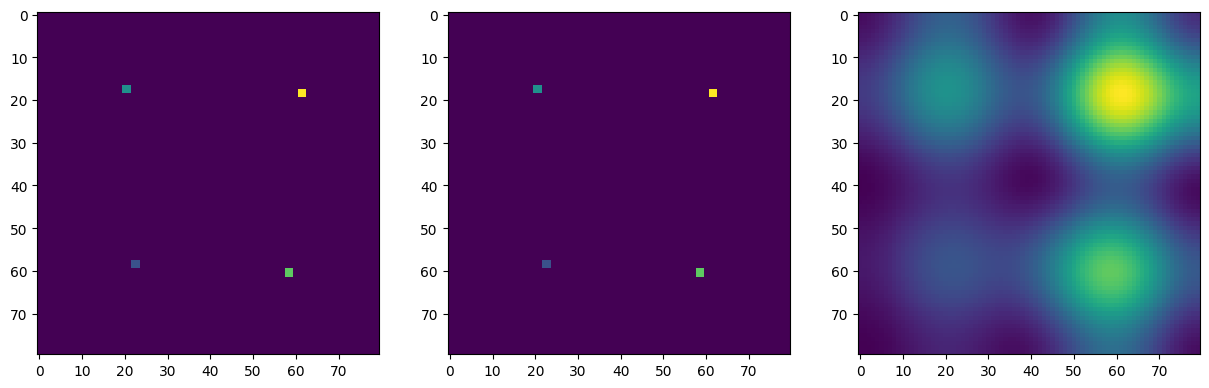

In [447]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

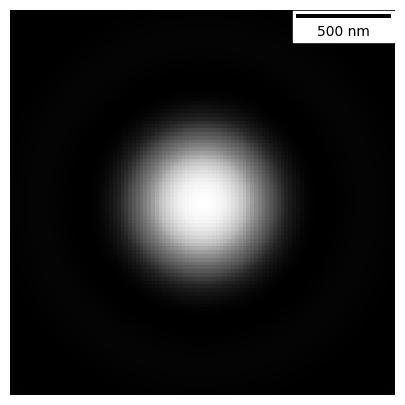

[[0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 ...
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]]


/home/boomalope/symbac/symbac/lib/python3.8/site-packages/SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


In [448]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.0, 
    n = 1.4, 
    resize_amount = 1, 
    pix_mic_conv = 0.02, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
print(psf)

In [449]:
#Get all sourcePts

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

print(sourcePts)

#Assemble the matrix
additionalPts = []
for _ in range(0):
    x = random.randint(0,len(out)-1)
    y = random.randint(0,len(out[0])-1)
    additionalPts.append([x,y])

#Include points along the edge
for i in range(len(out)):
    additionalPts.append([i,0])
    additionalPts.append([i,len(out[0])-1])
for i in range(len(out[0])):
    additionalPts.append([0,i])
    additionalPts.append([len(out)-1,i])

print(len(additionalPts))

16
[[18, 20], [18, 62], [18, 21], [59, 22], [58, 23], [58, 22], [19, 61], [17, 21], [61, 59], [60, 59], [18, 61], [60, 58], [61, 58], [19, 62], [17, 20], [59, 23]]


In [450]:
def AverageFilter(img, x, y):
    sz = [ -2, -1, 0 , 1, 2]
    total = 0
    for i in sz:
        for j in sz:
            if x+i >= 0 and x+i < len(img) and y+j >= 0 and y+j < len(img[0]):
                total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

def getPSF(origin,target,psf):
    assert(len(psf)%2 == 1) and (len(psf[0])%2 == 1)
    centre = [int(len(psf)/2),int(len(psf[0])/2)]
    shifted_target = [target[0]-origin[0]+centre[0],target[1]-origin[1]+centre[1]]
    if (shifted_target[0] < 0 or shifted_target[0] >= len(psf)) or (shifted_target[1] < 0 or shifted_target[1] >= len(psf[0])):
        return 0
    else:
        return psf[shifted_target[0]][shifted_target[1]]

In [451]:
b = []
for (x,y) in sourcePts:
    b.append(AverageFilter(out,x,y))
for (x,y) in additionalPts:
    b.append(AverageFilter(out,x,y))
b = np.array(b)
b = b/(2**16-1)

A = []

for x in sourcePts:
    a = []
    for y in sourcePts:
        a.append(getPSF(y,x,psf))
    A.append(a)
for x in additionalPts:
    a = []
    for y in sourcePts:
        a.append(getPSF(y,x,psf))
    A.append(a)
A = np.array(A)

#Solve the matrix
x_bar = np.linalg.lstsq(A, b)
print(x_bar)

b_ori = []
for (x,y) in sourcePts:
    b_ori.append(ori[x][y])
b_ori = np.array(b_ori)
print(b_ori)

(array([ 2.1300745 , -4.45951722, -2.34651823,  0.61588756,  0.20460954,
       -0.2727928 , -6.27498163,  2.16657663, -1.87339662,  2.88891121,
        5.82837697, -3.14442426,  2.86000755,  5.87662261, -1.46360895,
       -0.30195322]), array([0.00595095]), 16, array([5.21412877, 4.89499405, 4.71739485, 4.29824392, 0.21722154,
       0.19559854, 0.18720195, 0.17560772, 0.16535178, 0.16089123,
       0.15196839, 0.12700238, 0.00830949, 0.00770839, 0.00733815,
       0.00611226]))
[0.5  1.   0.5  0.25 0.25 0.25 1.   0.5  0.75 0.75 1.   0.75 0.75 1.
 0.5  0.25]


/tmp/ipykernel_357111/2520729287.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_bar = np.linalg.lstsq(A, b)


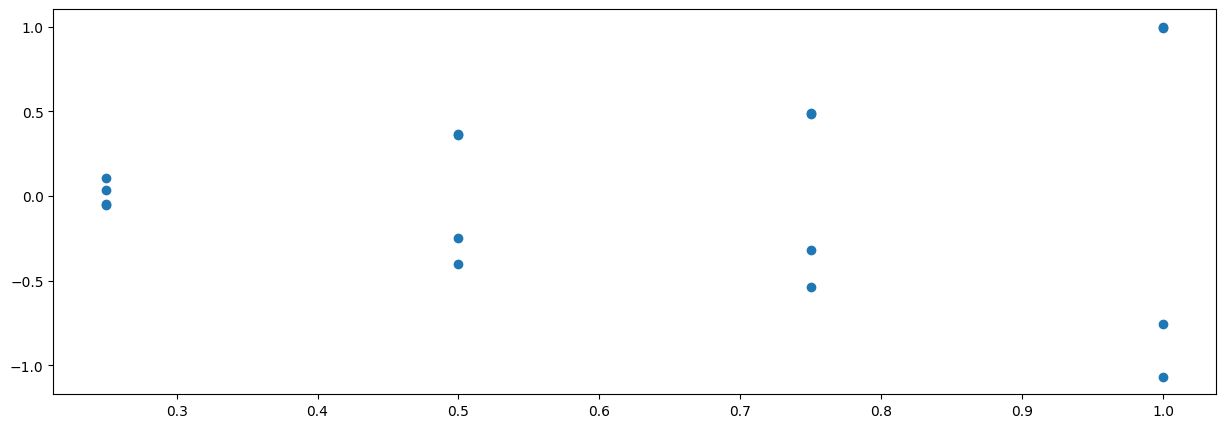

In [452]:
#Plot the result
plt.scatter(b_ori, x_bar[0]/max(x_bar[0]))

In [453]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import LinearConstraint

In [454]:
bounds = Bounds([0]*len(sourcePts), [1]*len(sourcePts))


[[1.00000000e+00 1.72860032e-02 9.96424529e-01 ... 1.72915383e-02
  9.96424529e-01 1.66617326e-02]
 [1.72860032e-02 1.00000000e+00 1.65562772e-02 ... 9.96424529e-01
  1.72915383e-02 4.72678231e-04]
 [9.96424529e-01 1.65562772e-02 1.00000000e+00 ... 1.65683160e-02
  9.92859717e-01 1.66039498e-02]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.66691574e-02 0.00000000e+00 ... 4.39169749e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] [5.04037232e-01 9.84437629e-01 5.03815671e-01 2.59511406e-01
 2.58385290e-01 2.59095750e-01 9.86158846e-01 5.03642939e-01
 7.45795071e-01 7.46763104e-01 9.85436179e-01 7.46423133e-01
 7.45417258e-01 9.85200580e-01 5.03851072e-01 2.58783246e-01
 1.42659648e-02 5.26320287e-02 2.00924697e-02 7.33348592e-02
 2.67960632e-02 9.66317235e-02 3.01017777e-02 1.06411536e-01
 3.43523308e-02 1.19025864e-01 3.9